# 추상적 요약, 추출적 요약 만들기

## 뉴스기사 추상적요약, 추출적 요약

- 뉴스기사의 원문과 실제 요약한 csv 데이터 불러오기
- 데이터 확인하기
- 데이터 전처리하기
- 불용어 사전 및 텍스트 불용어 확인
- 불용어 제거 및 전처리
- 전처리 한 데이터 사용
- 길이 분포 출력
- 소수의 이상치 제거를 위한 길이 책정
    - 그 어떤 데이터도 제거되지 않았다...
- 모델 설계(구성)
- 모델 학습
- 모델 학습 시각화
    - epochs가 많아서 그런지 결국 마지막에는 뜨문뜨문 loss값이 줄어들다가 과적합 모양이 나와버림
- 추상적 요약 출력 및 Bleu 점수, Rouge 점수
    - 어떤 것들은 점수가 쓸만하게 나왔지만, 대부분 0에 수렴해버리는 안타까운 현실
- 추출적 요약
    - 추출적 요약
    - 재귀함수 사용 추출적 요약
    - csv 파일 랜덤으로 추출해서 원문, 추출적 요약 출력
- 회고

In [1]:
from importlib.metadata import version
import nltk
import tensorflow
!pip install summa
import summa
import pandas

print(nltk.__version__)
print(tensorflow.__version__)
print(pandas.__version__)
print(version('summa'))

3.6.5
2.6.0
1.3.3
1.2.0


In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # 메모리 사용 제한을 위한 설정
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    # 특정 GPU만 사용하도록 설정
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
  except RuntimeError as e:
    # 프로그램 시작 후에는 GPU 설정을 변경할 수 없으므로
    # 런타임 오류 발생 시 예외 처리가 필요함
    print(e)

Num GPUs Available:  1


In [3]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 데이터 불러오기

In [4]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

## 데이터 확인하기

In [5]:
display(data.sample(10))
print("-------------------"*2)
data.info()

,headlines,text
28213,Gem-encrusted balls being sold in Russia for Ã...,A store in Russia's Saransk has produced 11 je...
10754,Exploring legal angles: CM on renaming Ahmedab...,Gujarat Chief Minister Vijay Rupani on Thursda...
32949,Tightened loan norms to curb frauds: PNB,Punjab National Bank (PNB) has said it has tig...
19194,Banks serve summons to defaulters through What...,Banks have started sending summons to defaulte...
61255,Twitter users share photos of Jupiter and Venu...,Twitter users across the UK and US shared imag...
10632,400 buffaloes drown fleeing lions in Botswana,Over 400 buffaloes believed to have been chase...
39939,'Cramped' NCERT syllabus to be reduced to half...,Human Resource Development Minister Prakash Ja...
17277,Typhoon Mangkhut could cause $120 billion in d...,"Super Typhoon Mangkhut, the most powerful stor..."
82063,"Smriti Irani compares Jon Snow, Mihir Virani",Smriti Irani shared actor Kit Harington's phot...
64269,Harry Potter series pitch rejected by publishe...,Harry Potter author JK Rowling's original seri...


--------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98401 entries, 0 to 98400
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   headlines  98401 non-null  object
 1   text       98401 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB


In [6]:

print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))
print(data.isnull().sum())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280
전체 샘플수 : 98360
headlines    0
text         0
dtype: int64


## 불용어 사전 및 텍스트 불용어 확인

In [7]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

정규화 사전의 수:  120
불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', '

## 불용어 제거 및 전처리

In [8]:
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah

    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [9]:
import multiprocessing as mp   # 멀티 프로세싱으로 전처리 속도를 획기적으로 줄여봅시다
from multiprocessing import Pool
import numpy as np
import time
from functools import partial  # map을 할 때 함수에 여러 인자를 넣어줄 수 있도록 합니다

start = time.time()

# num_cores 만큼 쪼개진 데이터를 전처리하여 반환합니다
def appendTexts(sentences, remove_stopwords):
  texts = []
  for s in sentences:
    texts += preprocess_sentence(s, remove_stopwords),
  return texts

def preprocess_data(data, remove_stopwords=True):
  start_time = time.time()
  num_cores = mp.cpu_count()  # 컴퓨터의 코어 수를 구합니다

  text_data_split = np.array_split(data, num_cores)  # 코어 수만큼 데이터를 배분하여 병렬적으로 처리할 수 있게 합니다
  pool = Pool(num_cores)

  processed_data = np.concatenate(pool.map(partial(appendTexts, remove_stopwords=remove_stopwords), text_data_split))  # 각자 작업한 데이터를 하나로 합쳐줍니다
  pool.close()
  pool.join()
  print(time.time() - start_time, " seconds")
  return processed_data

# text 전처리
clean_text = preprocess_data(data['text'])
print(clean_text)

# headlines 전처리
clean_headlines = preprocess_data(data['headlines'], remove_stopwords=False)
print(clean_headlines)

392.0326466560364  seconds
['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers'
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit'
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history'
 ...
 'according reports new version science fiction film matrix development michael jordan reportedly play lead role film screenwriter zak 

## 전처리 한 데이터 사용

In [10]:
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [11]:
# clean_text = []
# for text in data['text']:
#     clean_text.append(preprocess_sentence(text))

# # 전처리 후 출력
# print("Text 전처리 후 결과: ", clean_text[:5])

In [12]:
# clean_headlines = []

# for headlines in data['headlines']:
#     clean_headlines.append(preprocess_sentence(headlines, remove_stopwords=False))

## 길이 분포 출력

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


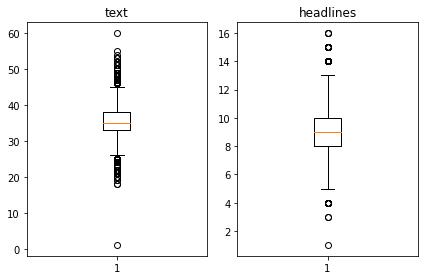

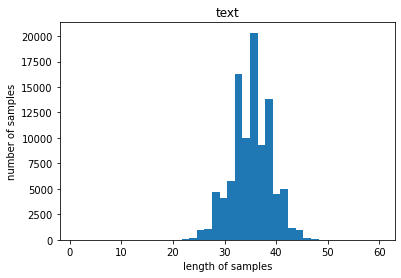

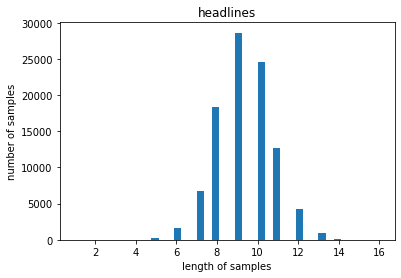

In [13]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [14]:
df = data.copy()

## 소수의 이상치 제거를 위한 길이 책정

In [15]:
text_max_len = 43
headlines_max_len = 12

In [16]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [17]:
below_threshold_len(text_max_len, df['text'])
below_threshold_len(headlines_max_len,  df['headlines'])

전체 샘플 중 길이가 43 이하인 샘플의 비율: 0.9871797478649857
전체 샘플 중 길이가 12 이하인 샘플의 비율: 0.9880337535583571


In [18]:
# 'text' 컬럼에 대한 길이 제한 및 제외
df['text'] = df['text'].apply(lambda x: x if len(x.split()) <= text_max_len else None)

# 'headlines' 컬럼에 대한 길이 제한 및 제외
df['headlines'] = df['headlines'].apply(lambda x: x if len(x.split()) <= headlines_max_len else None)

# 길이가 큰 샘플 제외한 결과 출력
df = df.dropna(subset=['text', 'headlines'])

# 결과 출력
print("text 전처리 후 결과: ", df['text'].tolist()[:5])
print("headlines 전처리 후 결과: ", df['headlines'].tolist()[:5])

text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical illnesses disability accidental death benefit rider life cover age years', 'pakistani singer rahat fateh ali khan denied receiving notice enforcement directorate allegedly smuggling foreign currency india would better authorities would served notice first public

In [19]:
df['headlines'].isnull().sum()

0

In [20]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
df['decoder_input'] = df['headlines'].apply(lambda x : 'sostoken '+ x)
df['decoder_target'] = df['headlines'].apply(lambda x : x + ' eostoken')
df.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
6,india get all out for their lowest odi total i...,india recorded lowest odi total new zealand ge...,sostoken india get all out for their lowest od...,india get all out for their lowest odi total i...


In [21]:
encoder_input = np.array(df['text']) # 인코더의 입력
decoder_input = np.array(df['decoder_input']) # 디코더의 입력
decoder_target = np.array(df['decoder_target']) # 디코더의 레이블

In [22]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[33646 32486 61565 ... 19667 10465 86007]


In [23]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [24]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19187


In [25]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 76748
훈련 레이블의 개수 : 76748
테스트 데이터의 개수 : 19187
테스트 레이블의 개수 : 19187


In [26]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [27]:
threshold = 12
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 68279
등장 빈도가 11번 이하인 희귀 단어의 수: 51857
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 16422
단어 집합에서 희귀 단어의 비율: 75.94868114647257
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.27165130526584


In [28]:
src_vocab = 16000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [29]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[462, 84, 31, 5178, 7525, 35, 2297, 338, 1888, 42, 51, 6855, 608, 6856, 18, 84, 657, 8681, 60, 563, 976, 1078, 365, 414, 1124, 1375, 462, 32, 51, 196, 1264, 1907, 7890, 7423, 88, 762, 608], [717, 1465, 101, 1916, 536, 2302, 54, 218, 4913, 1513, 3548, 1454, 473, 188, 85, 3142, 54, 473, 398, 52, 3114, 5342, 325, 473, 319, 633, 54, 2378, 1465, 674, 3549, 1916, 674, 1513, 3548], [27, 98, 19, 58, 70, 1495, 209, 2102, 787, 8137, 773, 2786, 14562, 845, 316, 755, 525, 1686, 1699, 1123, 275, 5488, 2021, 2047, 14047, 1271, 2648, 24, 2658, 2806, 4]]


In [30]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [31]:
threshold = 7
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29715
등장 빈도가 6번 이하인 희귀 단어의 수: 20319
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9396
단어 집합에서 희귀 단어의 비율: 68.37960625946492
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.4257615979037555


In [32]:
tar_vocab = 9000
tar_tokenizer = Tokenizer(num_words=tar_vocab)
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train)
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 248, 1470, 5314, 6, 2020, 428, 13, 51, 437], [1, 777, 2225, 172, 188, 14, 837, 1420], [1, 2930, 586, 701, 5, 1007, 7112, 1722, 5, 265, 505, 122], [1, 3621, 292, 212, 3, 2584, 105, 513, 371, 4, 727], [1, 696, 36, 745, 548, 3, 426, 15, 4, 60]]
target
decoder  [[248, 1470, 5314, 6, 2020, 428, 13, 51, 437, 2], [777, 2225, 172, 188, 14, 837, 1420, 2], [2930, 586, 701, 5, 1007, 7112, 1722, 5, 265, 505, 122, 2], [3621, 292, 212, 3, 2584, 105, 513, 371, 4, 727, 2], [696, 36, 745, 548, 3, 426, 15, 4, 60, 2]]


In [33]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 76748
훈련 레이블의 개수 : 76748
테스트 데이터의 개수 : 19187
테스트 레이블의 개수 : 19187


In [34]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

## 모델 설계(구성)

In [35]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout = 0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout = 0.4)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

In [36]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout = 0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [37]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 43)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 43, 128)      2048000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 43, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [38]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 43)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 43, 128)      2048000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 43, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

## 모델 학습

In [39]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
300/300 [==============================] - 135s 421ms/step - loss: 5.6958 - val_loss: 5.3102
Epoch 2/50
300/300 [==============================] - 125s 416ms/step - loss: 5.2003 - val_loss: 4.9145
Epoch 3/50
300/300 [==============================] - 125s 418ms/step - loss: 4.7021 - val_loss: 4.4613
Epoch 4/50
300/300 [==============================] - 125s 416ms/step - loss: 4.2824 - val_loss: 4.1709
Epoch 5/50
300/300 [==============================] - 125s 418ms/step - loss: 3.9763 - val_loss: 3.9727
Epoch 6/50
300/300 [==============================] - 125s 417ms/step - loss: 3.7378 - val_loss: 3.8380
Epoch 7/50
300/300 [==============================] - 125s 417ms/step - loss: 3.5449 - val_loss: 3.7395
Epoch 8/50
300/300 [==============================] - 125s 417ms/step - loss: 3.3824 - val_loss: 3.6737
Epoch 9/50
300/300 [==============================] - 125s 416ms/step - loss: 3.2428 - val_loss: 3.6261
Epoch 10/50
300/300 [==============================] - 125s 417m

## 모델 학습 시각화

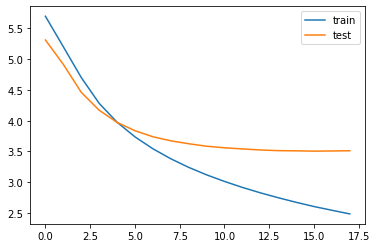

In [40]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [41]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [42]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])


In [43]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat)

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [44]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [45]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp = ''
    for i in input_seq:
        if i == tar_word_to_index['eostoken']:
            break
        elif i != 0 and i != tar_word_to_index['sostoken']:
            temp += tar_index_to_word[i] + ' '
    return temp

## 추상적 요약 출력 및 Bleu 점수, Rouge 점수

In [57]:
!pip install rouge

In [58]:
!pip install rouge_score

In [59]:
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer

def calculate_bleu_score(reference, candidate):
    smooth = SmoothingFunction().method1  # BLEU smoothing function
    return corpus_bleu([[reference]], [candidate], smoothing_function=smooth)

def calculate_rouge_score(reference, candidate):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(reference, candidate)
    return scores

In [69]:
for i in range(0, 10):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("="* 100)
    # BLEU 계산
    bleu_score = calculate_bleu_score(seq2summary(decoder_input_test[i]), decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print(f"BLEU Score: {bleu_score:.4f}")
    print("="* 100)
    # ROUGE 점수 계산
    rouge_score = calculate_rouge_score(seq2summary(decoder_input_test[i]), decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print(f"ROUGE-1 Score: {rouge_score['rouge1'].fmeasure:.4f}")
    print(f"ROUGE-2 Score: {rouge_score['rouge2'].fmeasure:.4f}")
    print(f"ROUGE-L Score: {rouge_score['rougeL'].fmeasure:.4f}")
    print("*"* 100)
    print("\n")

원문 : union minister arun jaitley tuesday took dig congress saying reservation jumla mention congress manifesto general polls jaitley comment came opposition questioned timing behind government move include economically weaker categories within general category reservation reservation aimed give equality said 
실제 요약 : reservation was in congress manifesto jaitley 
예측 요약 :  congress is the congress in jaitley
BLEU Score: 0.4594
ROUGE-1 Score: 0.5000
ROUGE-2 Score: 0.0000
ROUGE-L Score: 0.3333
****************************************************************************************************


원문 : indian cricketer yusuf pathan failed dope test last year ranji trophy season following bcci asked baroda pick according report rounder reportedly took medicine feeling unwell however failed apply use exemption taking medicine 
실제 요약 : yusuf failed dope test baroda told to not pick him report 
예측 요약 :  harbhajan singh yusuf pathan fails to play ipl
BLEU Score: 0.2224
ROUGE-1 Score: 0.3158
ROUGE

In [46]:
for i in range(0, 4):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : union minister arun jaitley tuesday took dig congress saying reservation jumla mention congress manifesto general polls jaitley comment came opposition questioned timing behind government move include economically weaker categories within general category reservation reservation aimed give equality said 
실제 요약 : reservation was in congress manifesto jaitley 
예측 요약 :  congress is the congress in jaitley


원문 : indian cricketer yusuf pathan failed dope test last year ranji trophy season following bcci asked baroda pick according report rounder reportedly took medicine feeling unwell however failed apply use exemption taking medicine 
실제 요약 : yusuf failed dope test baroda told to not pick him report 
예측 요약 :  harbhajan singh yusuf pathan fails to play ipl


원문 : facebook account shah rukh khan son aryan khan hacked aryan took instagram story wrote facebook hacked please ignore anything aryan california pursuing education filmmaking earlier twitter accounts celebrities like anupam khe

## 추출적 요약

In [54]:
import requests
from summa.summarizer import summarize # Extractive summary를 위한 library

In [55]:
data2 = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [67]:
for idx, text in enumerate(data2['text'][:3]):
    print(f'<원문_{idx+1}:> \n{text}\n')
    print(f'[요약:] \n{summarize(text, words=20)}\n')
    print('-'*100)

<원문_1:> 
Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.

[요약:] 
The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike.
upGrad's Online Power Learning has powered 3 lakh+ careers.

----------------------------------------------------------------------------------------------------
<원문_2:> 
Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixig

### 재귀함수 사용 추출적 요약

In [61]:
def recall_summarize(summarize, sentence, words):
    return_sentence = summarize(sentence, words=words)
    if len(return_sentence) == 0:
        words += 1
        return recall_summarize(summarize, sentence, words)
    else:
        return return_sentence

In [62]:
for i in range(0, 10):
    print("원문 :", data2['text'][i])
    print("실제 요약 :", data2['headlines'][i])
    print("추출적 요약 :", recall_summarize(summarize, data2['text'][i], 5))
    print("\n")

원문 : Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
실제 요약 : upGrad learner switches to career in ML & Al with 90% salary hike
추출적 요약 : upGrad's Online Power Learning has powered 3 lakh+ careers.


원문 : Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
실제 요약 : Delhi techie wins free food from Swiggy for one year on CRED
추출적 요약 : Users get one CRED coin per rupee of bill p

### csv 파일 랜덤으로 추출해서 원문, 추출적 요약 출력

In [63]:
# Randomly select 40 texts
random_sample = data2.sample(n=40)

In [64]:
for idx, text in enumerate(random_sample['text'][:3]):
    print(f'원문_{idx+1} \n{text}')
    print(f'요약 \n{summarize(text, words=20)}\n')

원문_1 
The Home Ministry rejected the highest proportion of RTI requests, 15% of the nearly 58,000 applications it had received, according to the annual report released by Central Information Commission. It was followed by Finance Ministry which rejected 14% of the nearly 2 lakh requests. The Railway Ministry and Ministry of Housing and Urban Affairs rejected lowest proportion of applications.
요약 
The Home Ministry rejected the highest proportion of RTI requests, 15% of the nearly 58,000 applications it had received, according to the annual report released by Central Information Commission.

원문_2 
The 1993 Mumbai blasts mastermind Dawood Ibrahim is willing to return to India and face all charges against him if the government keeps him in Mumbai's Arthur Road jail, criminal lawyer Shyam Keswani has claimed. Dawood offered the conditional return a few years ago too but the government refused and till this day he has not been arrested, Keswani added.
요약 
The 1993 Mumbai blasts mastermind D

## 회고

평가분석을 했을 때 결과가 매우 좋지 않게 나왔습니다.

1에 가까울수록 좋은 결과라고 했으나, 0에 수렴하는 결과가 많이 발생 했습니다.

NLP로 이런 프로젝트를 해보는 것도 처음이였고, CV만 하다보니까 하나도 모르겠습니다.

사실 노드를 봐도 너무 생소한 느낌들이 많이 들어서 집중도 잘 안됬습니다. 하하하하...

- K
    - 없습니다.
- P
    - 1. clean_text 와 clean_headlines를 만들고 다시 data의 칼럼에 넣지 않았습니다.
    - 2. reconnect_drop을 초기에 설정하지 않았었습니다.
    - 3. 추출적 요약에서 matrix txt 파일을 가져와서 실행을 하고 끝난줄 알았습니다.
    - 4. 많은 실수들을 너무 늦게 깨달았습니다.
- T
    - 1. 다른사람에게 최대길이, 평균길이를 물어보고 코드에 문제가 있었던 것을 발견
    - 2. reconnect_drop을 추가하여 훈련을 진행 시킨 점
    - 3. 추출적 요약에 DataFrame 원문을 다시 가져와 실행했습니다.
    - 4. 평가 지표로 Bleu와 Rogue를 넣었습니다.